# Real-time Pose Detection and Classification

This notebook demonstrates how to use MediaPipe Pose Landmarker to detect and classify yoga poses in real-time using a webcam.

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [2]:
# Create a PoseLandmarker object.
base_options = mp.tasks.BaseOptions(
    model_asset_path='pose_landmarker.task'
)
options = mp.tasks.vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
pose_landmarker = mp.tasks.vision.PoseLandmarker.create_from_options(options)

I0000 00:00:1767885770.736433 10730724 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1767885770.822283 10730725 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1767885770.838908 10730726 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [3]:
# from pose_utils import (
#     calculate_angle,
#     classify_warrior2,
#     classify_warrior1,
#     classify_tree_pose,
#     classify_triangle_pose,
#     classify_mountain_pose,
#     classify_plank_pose
# )

In [4]:
from pose_utils import (
    calculate_angle,
    # classify_warrior2_refined,
    # classify_warrior1_refined,
    # classify_tree_pose_refined,
    # classify_triangle_pose_refined,
    # classify_mountain_pose_refined,
    # classify_plank_pose_refined,
    classify_warrior2_v2,
    classify_warrior1_v2,
    classify_tree_v2,
    classify_triangle_v2,
    classify_mountain_v2,
    classify_plank_v2

)

In [5]:
def classify_poses(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle, shoulder_l, wrist_l, shoulder_r, wrist_r, ankle_l, ankle_r, knee_l, knee_r, left_body_angle, right_body_angle):
    pose = "Unknown"

    if classify_warrior2_v2(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, shoulder_l, wrist_l, shoulder_r, wrist_r):
        pose = "Warrior 2"
    elif classify_warrior1_v2(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
        pose = "Warrior 1"
    elif classify_tree_v2(left_leg_angle, right_leg_angle, ankle_l, ankle_r, knee_l, knee_r):
        pose = "Tree Pose"
    elif classify_triangle_v2(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_body_angle, right_body_angle, left_shoulder_angle, right_shoulder_angle):
        pose = "Triangle Pose"
    elif classify_mountain_v2(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
        pose = "Mountain Pose"
    elif classify_plank_v2(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_body_angle, right_body_angle):
        pose = "Plank Pose"

    # if classify_warrior2_refined(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, shoulder_l, wrist_l, shoulder_r, wrist_r):
    #     pose = "Warrior 2"
    # elif classify_warrior1_refined(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
    #     pose = "Warrior 1"
    # elif classify_tree_pose_refined(left_leg_angle, right_leg_angle, ankle_l, ankle_r, knee_l, knee_r):
    #     pose = "Tree Pose"
    # elif classify_triangle_pose_refined(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_body_angle, right_body_angle, left_shoulder_angle, right_shoulder_angle):
    #     pose = "Triangle Pose"
    # elif classify_mountain_pose_refined(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
    #     pose = "Mountain Pose"
    # elif classify_plank_pose_refined(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_body_angle, right_body_angle):
    #     pose = "Plank Pose"
    return pose

        # if classify_warrior2(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle):
    #     pose = "Warrior 2"
    # elif classify_warrior1(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
    #     pose = "Warrior 1"
    # elif classify_tree_pose(left_leg_angle, right_leg_angle, ankle_l, ankle_r, knee_l, knee_r):
    #     pose = "Tree Pose"
    # elif classify_triangle_pose(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_body_angle, right_body_angle, left_shoulder_angle, right_shoulder_angle):
    #     pose = "Triangle Pose"
    # elif classify_mountain_pose(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle):
    #     pose = "Mountain Pose"
    # elif classify_plank_pose(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, shoulder_l, ankle_l, shoulder_r, ankle_r):
    #     pose = "Plank Pose"
    


In [6]:
def process_and_annotate(image, landmark_list):
    annotated_image = image.copy()
    landmarks = landmark_list
    # Get coordinates
    shoulder_l = [landmarks[11].x,landmarks[11].y]
    elbow_l = [landmarks[13].x,landmarks[13].y]
    wrist_l = [landmarks[15].x,landmarks[15].y]

    shoulder_r = [landmarks[12].x,landmarks[12].y]
    elbow_r = [landmarks[14].x,landmarks[14].y]
    wrist_r = [landmarks[16].x,landmarks[16].y]

    hip_l = [landmarks[23].x,landmarks[23].y]
    knee_l = [landmarks[25].x,landmarks[25].y]
    ankle_l = [landmarks[27].x,landmarks[27].y]

    hip_r = [landmarks[24].x,landmarks[24].y]
    knee_r = [landmarks[26].x,landmarks[26].y]
    ankle_r = [landmarks[28].x,landmarks[28].y]

    # Calculate angles
    left_arm_angle = calculate_angle(shoulder_l, elbow_l, wrist_l)
    right_arm_angle = calculate_angle(shoulder_r, elbow_r, wrist_r)
    left_leg_angle = calculate_angle(hip_l, knee_l, ankle_l)
    right_leg_angle = calculate_angle(hip_r, knee_r, ankle_r)
    left_shoulder_angle = calculate_angle(hip_l, shoulder_l, wrist_l)
    right_shoulder_angle = calculate_angle(hip_r, shoulder_r, wrist_r)
    left_body_angle = calculate_angle(shoulder_l, hip_l, knee_l)
    right_body_angle = calculate_angle(shoulder_r, hip_r, knee_r)

    pose = classify_poses(left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle, left_shoulder_angle, right_shoulder_angle, shoulder_l, wrist_l, shoulder_r, wrist_r, ankle_l, ankle_r, knee_l, knee_r, left_body_angle, right_body_angle) 

    # Display the pose
    # Display the pose with outline for better visibility
    # Outline (black)
    cv2.putText(annotated_image, pose, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 10, cv2.LINE_AA)
    # Text (white for high contrast)
    cv2.putText(annotated_image, pose, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 3, cv2.LINE_AA)
    
    # Draw landmarks
    for idx, landmark in enumerate(landmark_list):
        x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
        cv2.circle(annotated_image, (x, y), 5, (0, 255, 0), -1)

    # Draw connections
    connections = mp.tasks.vision.PoseLandmarksConnections.POSE_LANDMARKS
    for connection in connections:
        start_idx = connection.start
        end_idx = connection.end
        start_point = (int(landmark_list[start_idx].x * image.shape[1]),
                       int(landmark_list[start_idx].y * image.shape[0]))
        end_point = (int(landmark_list[end_idx].x * image.shape[1]),
                     int(landmark_list[end_idx].y * image.shape[0]))
        cv2.line(annotated_image, start_point, end_point, (255, 0, 0), 2)
    
    return annotated_image

In [7]:
# Initialize the video capture from the default camera.
# cap = cv2.VideoCapture(1)
# 
# try:
#     while cap.isOpened():
#         # Read a frame from the video.
#         success, image = cap.read()
#         if not success:
#             print("Ignoring empty camera frame.")
#             # If loading a video, use 'break' instead of 'continue'.
#             continue
# 
#         # Convert the BGR image to RGB.
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# 
#         # Process the image and get the pose landmarks.
#         mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
#         detection_result = detector.detect(mp_image)
# 
#         annotated_image = image.copy()
#         if detection_result.pose_landmarks:
#             for landmark_list in detection_result.pose_landmarks:
#                  annotated_image = process_and_annotate(image, landmark_list)
# 
#         # Convert the RGB image back to BGR for display.
#         annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
# 
#         # Display the annotated image.
#         cv2.imshow('MediaPipe Pose Landmark', annotated_image)
# 
#         # Break the loop if 'q' is pressed.
#         if cv2.waitKey(5) & 0xFF == ord('q'):
#             break
# except KeyboardInterrupt:
#     print("Program interrupted by user.")
# finally:
#     # Release the video capture and destroy all windows.
#     cap.release()
#     cv2.destroyAllWindows()

## Static Image Detection

Input an image path to run pose detection on a single image.

W0000 00:00:1767885771.343212 10730727 landmark_projection_calculator.cc:81] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


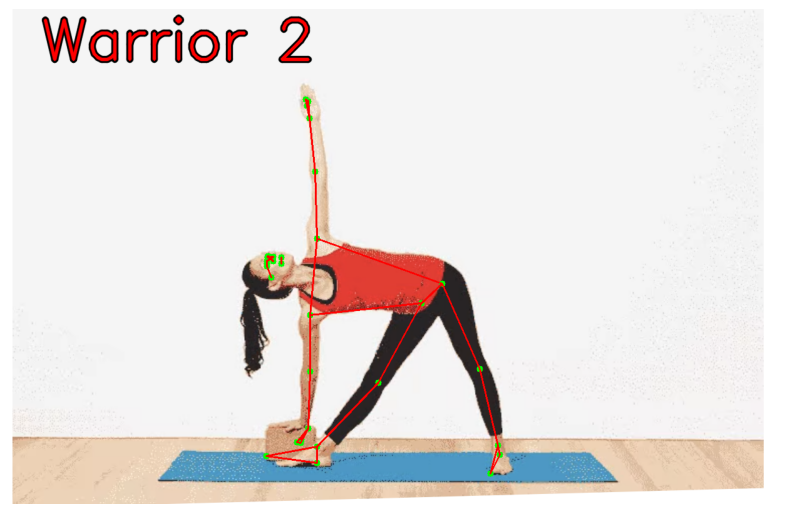

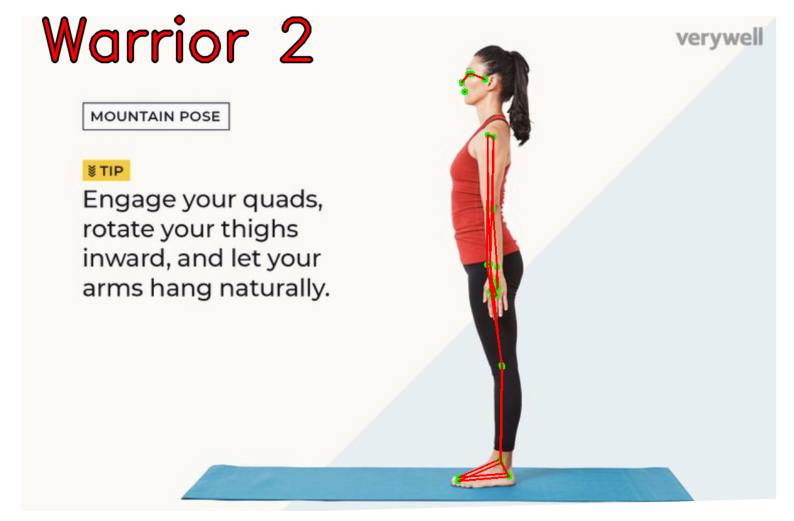

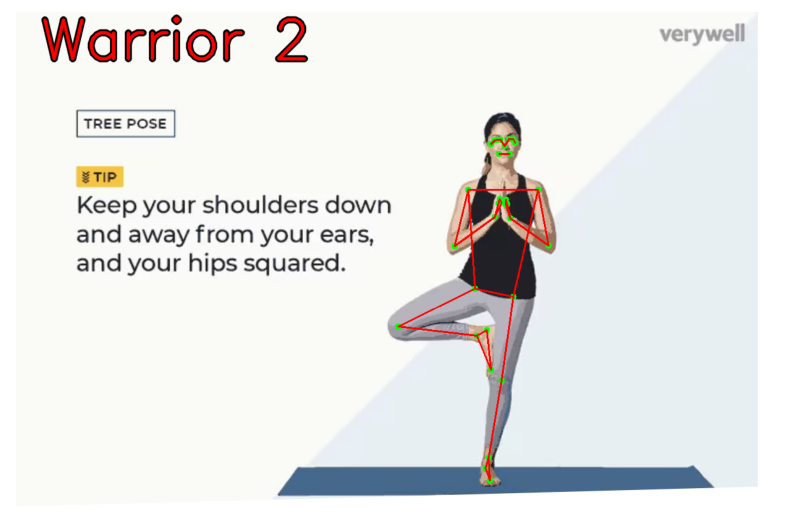

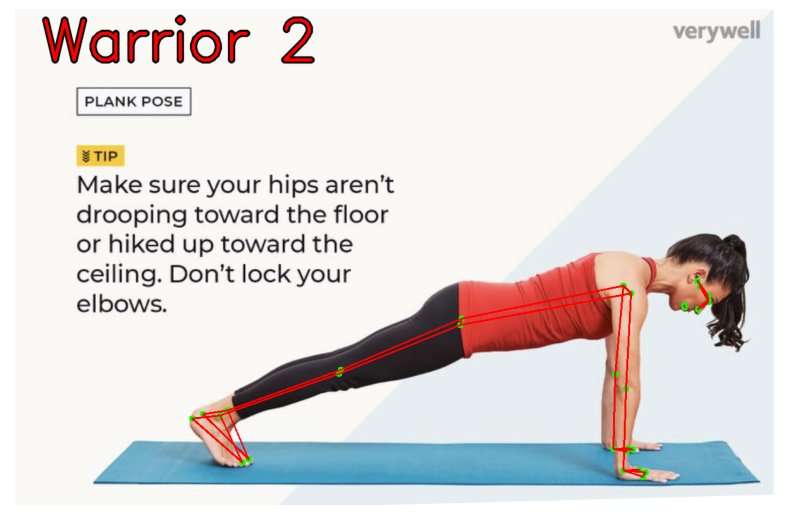

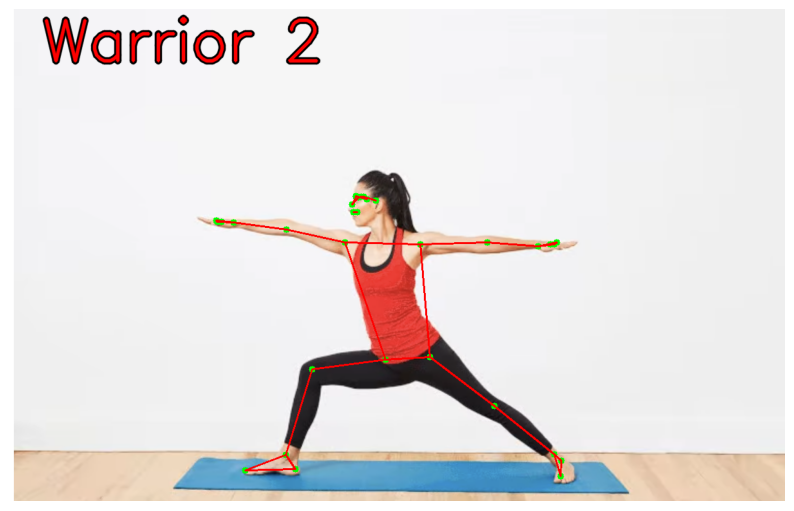

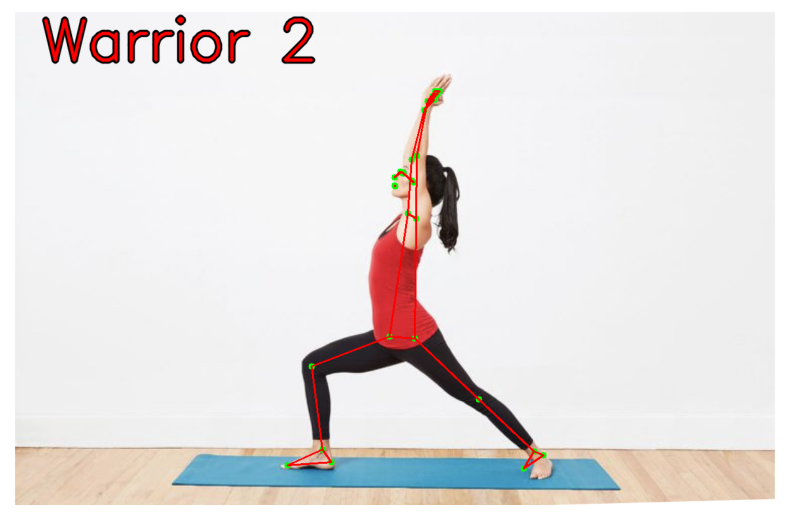

In [8]:
import matplotlib.pyplot as plt
import os

IMAGE_PATH = 'images'
images = os.listdir(IMAGE_PATH)

for image in images:
    image = cv2.imread(os.path.join(IMAGE_PATH, image))
    if image is None:
        print(f"Error: Could not read image from {IMAGE_PATH}. Please check the path.")
    else:
        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    landmarks = pose_landmarker.detect(mp_image)

    # Draw the pose annotation on the image.
    annotated_image = image.copy()
    if landmarks.pose_landmarks:
        for landmark_list in landmarks.pose_landmarks:
            annotated_image = process_and_annotate(image, landmark_list)

    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.show()

In [ ]:
# # Create the options that will be used for ImageSegmenter
model_path = './selfie_segmenter_landscape.tflite'

BaseOptions = mp.tasks.BaseOptions
ImageSegmenter = mp.tasks.vision.ImageSegmenter
ImageSegmenterOptions = mp.tasks.vision.ImageSegmenterOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a image segmenter instance with the image mode:
options = ImageSegmenterOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE,
    output_category_mask=True)


: 

In [10]:
with ImageSegmenter.create_from_options(options) as segmenter:
    # Load the input image from an image file.
    mp_image = mp.Image.create_from_file('/images/warrior_1.png')

    # Perform image segmentation on the provided single image.
    # The image segmenter must be created with the image mode.
    segmented_masks = segmenter.segment(mp_image)
    category_mask = segmentation_result.category_mask

    # Generate solid color images for showing the output segmentation mask.
    image_data = image.numpy_view()
    fg_image = np.zeros(image_data.shape, dtype=np.uint8)
    fg_image[:] = MASK_COLOR
    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.2
    output_image = np.where(condition, fg_image, bg_image)

    print(f'Segmentation mask of {name}:')
    cv2.imshow(output_image)


: 

: 